### Regression with XGBoost

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats.mstats import winsorize
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [42]:
df=pd.read_csv('../appliances-energy.csv')
df.head(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [43]:
#Due to lot of zero enteries, this column is of not much use and will be ignored in rest of the model.
df.drop(columns='lights',axis=1,inplace=True)

In [45]:
df['date'] = pd.to_datetime(df['date'])
df= df.set_index('date')
df.index.name ='time'
df['date'] = df.index.date
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour

In [46]:
df2=pd.concat([df.groupby(['month','day','hour']).Appliances.sum(),
           df.groupby(['month','day','hour']).mean().drop('Appliances',axis=1)],axis=1)

In [47]:
def f(x):
    x = x +273.15
    return x

In [48]:
dfk=df2.copy()
temp_list=['T1','T2','T3','T4','T6','T5','T7','T8','T9','T_out','Tdewpoint']
for i in temp_list:
    dfk[i] = dfk[i].apply(f)

In [49]:
dfkw=pd.DataFrame()
others=['RH_4','RH_6','T7']
for i in others:
    dfkw['w_%s'%i]=dfk[i]

In [50]:
#One by one, we kept winsorization low ratio because it might cause some side effects if we increase that ratio too much.
dfkw['w_Appliances']=winsorize(dfk.Appliances,(0,0.105))
dfkw['w_T1']=winsorize(dfk.T1,(0.05,0.05))
dfkw['w_RH_1']=winsorize(dfk.RH_1,(0.01,0.01))
dfkw['w_T2']=winsorize(dfk.T2,(0,0.04))
dfkw['w_RH_2']=winsorize(dfk.RH_2,(0.01,0.01))
dfkw['w_T3']=winsorize(dfk.T3,(0,0.02))
dfkw['w_T4']=winsorize(dfk.T4,(0.01,0.01))
dfkw['w_T5']=winsorize(dfk.T5,(0,0.01))
dfkw['w_RH_5']=winsorize(dfk.RH_5,(0.001,0.07))
dfkw['w_T6']=winsorize(dfk.T6,(0,0.05))
dfkw['w_RH_7']=winsorize(dfk.RH_7,(0,0.04))
dfkw['w_T_out']=winsorize(dfk.T_out,(0,0.04))
dfkw['w_Press_mm_hg']=winsorize(dfk.Press_mm_hg,(0.012,0))
dfkw['w_RH_out']=winsorize(dfk.RH_out,(0.02,0))
dfkw['w_Windspeed']=winsorize(dfk.Windspeed,(0,0.02))
dfkw['w_Visibility']=winsorize(dfk.Visibility,(0.05,0.125))
dfkw['w_RH_3']=winsorize(dfk.RH_3,(0,0.001))
dfkw['w_T8']=winsorize(dfk.T8,(0.05,0))
dfkw['w_RH_8']=winsorize(dfk.RH_8,(0,0.01))
dfkw['w_T9']=winsorize(dfk.T9,(0,0.001))
dfkw['w_RH_9']=winsorize(dfk.RH_9,(0.001,0.001))
dfkw['w_Tdewpoint']=winsorize(dfk.Tdewpoint,(0,0.001))
dfkw['w_rv1']=winsorize(dfk.rv1,(0.005,0.005))
dfkw['w_rv2']=winsorize(dfk.rv2,(0.005,0.005))

In [33]:
df3=dfkw.copy()
dflog=pd.DataFrame()
for col in df3.columns:
    dflog['log_%s'%col]=np.log(df3[col])

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dflog)
min_max=scaler.transform(dflog)
scale_df=pd.DataFrame(min_max)
scale_df=scale_df.rename({0:'Appliances',1:'T1', 2:'RH_1', 3:'T2', 4:'RH_2', 5:'T3', 6:'RH_3', 7:'T4', 8:'RH_4',
       9:'T5', 10:'RH_5', 11:'T6', 12:'RH_6', 13:'T7', 14:'RH_7', 15:'T8', 16:'RH_8', 17:'T9', 18:'RH_9',
       19:'T_out', 20:'Press_mm_hg', 21:'RH_out', 22:'Windspeed', 24:'Visibility',25:'Tdewpoint', 26:'rv1', 27:'rv2'},axis=1)

In [54]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
X = scale_df.drop('Appliances',axis=1)
y = scale_df.Appliances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [55]:
xg_reg=xgb.XGBRegressor(objectibe="reg:linear",seed=123,silent=True)

In [56]:
xg_reg.fit(X_train,y_train)
y_pred=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE: %f'%(rmse))

RMSE: 0.029821


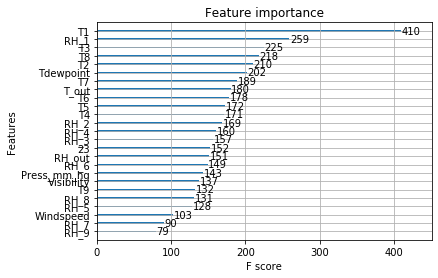

In [57]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [20]:
# Also lets try with lineer model for booster instead of decision tree.
DMtrain=xgb.DMatrix(data=X_train,label=y_train)
DMtest=xgb.DMatrix(data=X_test,label=y_test)
parameters={'booster':'gblinear','objective':'reg:linear'}
xg_reg=xgb.train(dtrain=DMtrain,params=parameters,num_boost_round=5)

In [22]:
# We trained our model. Let's see performance of the model.(According to root mean squared error)
y_pred_gblinear = xg_reg.predict(DMtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gblinear))
print("RMSE: %f" % (rmse))

RMSE: 0.101843


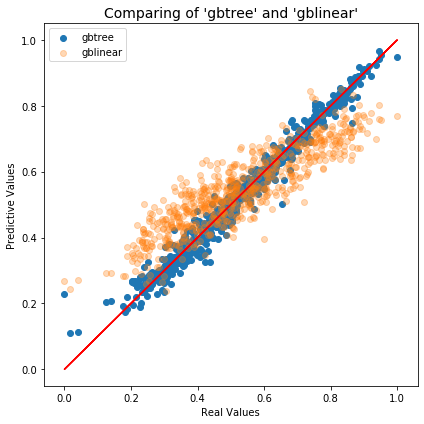

In [28]:
# Comparing of these two models on the graphic
plt.figure(figsize=(6,6))
plt.title("Comparing of 'gbtree' and 'gblinear'", size = 14)
ax1 = plt.scatter(y_test, y_pred)
ax2 = plt.scatter(y_test, y_pred_gblinear, alpha=0.30)
ax3 = plt.plot(y_test, y_test, color="red")
plt.legend((ax1, ax2), ('gbtree', 'gblinear'))
plt.xlabel("Real Values")
plt.ylabel("Predictive Values")
plt.tight_layout()
plt.show()

### Classification with XGBoost

In [62]:
from xgboost import XGBClassifier

In [63]:
telco=pd.read_csv('../telco_customer_churn.csv')
telco.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [64]:
telco.dropna(inplace=True)
telco=telco.drop(['customerID'],axis=1)
target=['Churn']
categorical=telco.select_dtypes(include='object').columns.tolist()
categorical=[x for x in categorical if x not in target]
numeric=telco.dtypes[telco.dtypes!=object].keys().tolist()

In [65]:
telco.Churn=telco.Churn.replace({"Yes":1, "No":0})
telco2=pd.concat([telco,pd.get_dummies(telco[categorical])],axis=1).drop(telco[categorical],axis=1)

In [66]:
X=telco2.drop('Churn',axis=1)
y=telco2.Churn

In [79]:
from sklearn.preprocessing import StandardScaler
#Instantiate the scaler
scaler=StandardScaler()
Xsc=scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(Xsc,y,test_size=0.20, random_state=123,stratify = y)

In [80]:
# We will transform the data set with the DMatrix function
telco_dmatrix = xgb.DMatrix(data=X, label=y)

In [85]:
params = {"objective":"binary:logistic", "max_depth":5, "silent":1}
telco_cv = xgb.cv(dtrain=telco_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="auc", as_pandas=True, seed=123)
display(telco_cv)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.849014,0.001207,0.827208,0.002666
1,0.861017,0.001336,0.834505,0.001785
2,0.866829,0.001590,0.838616,0.002262
3,0.871140,0.001317,0.839443,0.001717
4,0.874203,0.001063,0.840375,0.000657


In [88]:
params = {"objective":"binary:logistic", "max_depth":5, "silent":1}
telco_cv = xgb.cv(dtrain=telco_dmatrix,params=params, nfold=3, 
                    num_boost_round=5, metrics="error", as_pandas=True, seed=123)
display(telco_cv)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.197075,0.000866,0.215532,0.009423
1,0.188272,0.005019,0.204033,0.004023
2,0.185077,0.002547,0.204174,0.005304
3,0.183870,0.003313,0.202896,0.005304
4,0.182096,0.003062,0.200199,0.003694


In [91]:
print('Accuracy Value : {:.2f}'.format((1-telco_cv["test-error-mean"]).max()))

Accuracy Value : 0.80


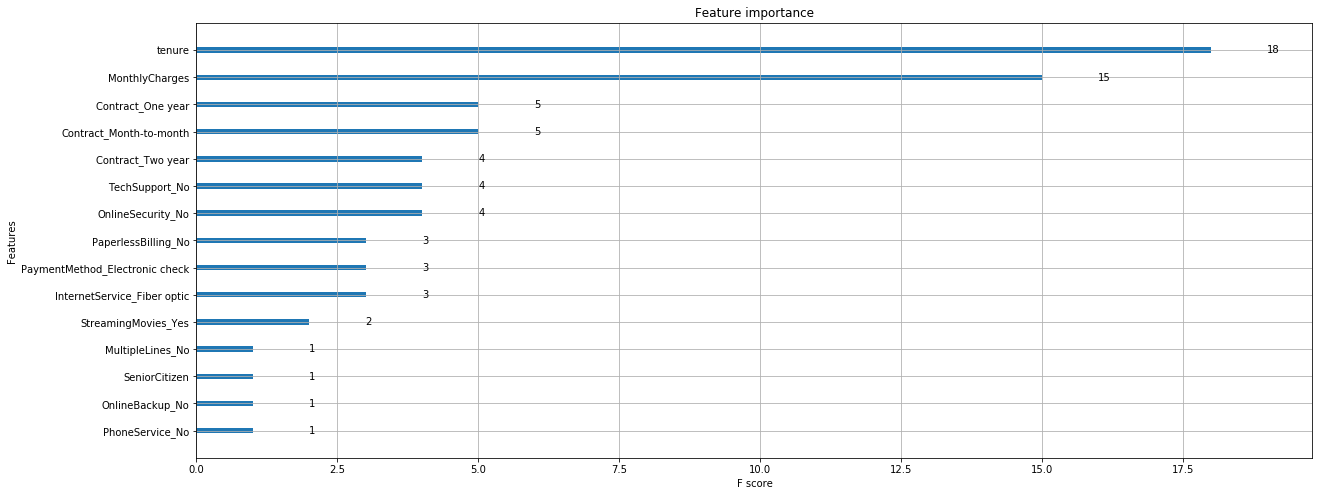

In [92]:
import matplotlib.pyplot as plt
telco_dmatrix = xgb.DMatrix(data=X, label=y)

best_parameters = {'objective':'binary:logistic',
                       'colsample_bytree': 0.7, 
                       'gamma': 0.1, 
                       'learning_rate': 0.3, 
                       'max_depth': 3, 
                       'min_child_weight': 3, 
                       'n_estimators': 50,
                       'silent':1
                      }

model_telco = xgb.train(params=best_parameters, dtrain=telco_dmatrix, num_boost_round=10)

ax = xgb.plot_importance(model_telco)
ax.figure.set_size_inches(20,8)
plt.show()